In [8]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]

In [26]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games


In [10]:

basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data','derived','cleaned_matches.csv')
cleaned_matches = pd.read_csv(data)

In [11]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date',inplace=True,ascending=True)
cleaned_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

## Train to classify based on the last-n-games a team played

In [27]:
check_dates, new_columns = form_last_n_games(cleaned_matches[:150], 3, ['Date'])
check_dates.head()

.................................................

,Day,Date,Home/Away,Opponent,Score,W/L/T,Overtime,Location,Venue,Attendance,...,Team,Team Code,Team Score,Opponent Score,Score Sum,Score Diff,Class,Team Code_p_Date,Team Code_pp_Date,Team Code_ppp_Date
16,Sun,1921-12-11,A,Washington Senators,0-7,L,NaN,"Washington, DC",National Park,5000.0,...,Cleveland Tigers,cle,0.0,7.0,7.0,-7.0,-1,1921-11-06,1921-10-23,1920-11-28
18,Sun,1922-10-15,H,Green Bay Packers,16-3,W,NaN,"Chicago, IL",Normal Park,3500.0,...,Chicago Cardinals,chic,16.0,3.0,19.0,13.0,1,1921-11-20,1921-10-02,1920-10-31
20,Sun,1922-10-22,A,Chicago Bears,0-7,L,NaN,"Chicago, IL",Cubs Park,6500.0,...,Buffalo All-Americans,buf,0.0,7.0,7.0,-7.0,-1,1921-11-06,1921-10-30,1920-11-28
22,Sun,1922-10-22,H,Minneapolis Marines,3-0,W,NaN,"Chicago, IL",Comiskey Park,4000.0,...,Chicago Cardinals,chic,3.0,0.0,3.0,3.0,1,1922-10-15,1921-11-20,1921-10-02
25,Sun,1922-11-05,H,Buffalo All-Americans,9-7,W,NaN,"Chicago, IL",Comiskey Park,4000.0,...,Chicago Cardinals,chic,9.0,7.0,16.0,2.0,1,1922-10-22,1922-10-15,1921-11-20


In [28]:
x_cols = [
  'Team Code',
  'Opponent Code',
]
y_cols = [
  'Class'
]

played_matches = cleaned_matches.dropna(axis=0, how='any', subset=x_cols + y_cols)

last_1_match, new_columns = form_last_n_games(played_matches, 3, ['Class'])

...

In [14]:

X = pd.concat([pd.get_dummies(last_1_match[xcol],prefix='_'.join(xcol.split())+'_') for xcol in x_cols] + [last_1_match[new_columns]], axis=1)
y = last_1_match[y_cols]


In [15]:
X.head()

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Opponent_Code__phi,Opponent_Code__pit,Opponent_Code__sd,Opponent_Code__sea,Opponent_Code__sf,Opponent_Code__stl,Opponent_Code__tb,Opponent_Code__was,Team Code_p_Class,Team Code_pp_Class
13,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1.0,-1.0
12,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1.0
14,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1.0
16,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,-1.0,1.0
18,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,1.0


In [16]:
y.head()

,Class
13,-1
12,1
14,0
16,-1
18,1


In [17]:
y=y.dropna()
X=X.dropna()

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
  X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=0
)


X_train, X_val, y_train, y_val = model_selection.train_test_split(
  X_train, y_train, test_size=0.25
)

y_train=y_train.ravel()
y_val=y_val.ravel()
y_test=y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(15636, 64) (15636,)
(5212, 64) (5212,)
(5212, 64) (5212,)


Evaluating linear kernel for C=0.01
Evaluating linear kernel for C=0.03760603093086394
Evaluating linear kernel for C=0.1414213562373095
Evaluating linear kernel for C=0.5318295896944989


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=2.0


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


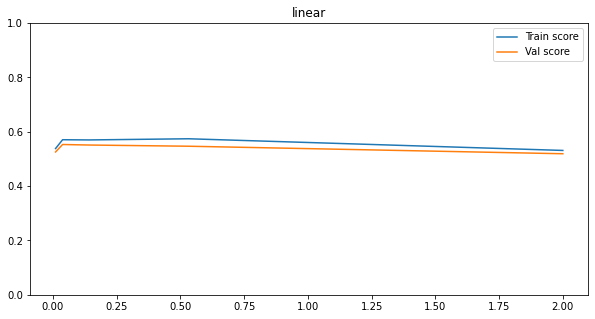

In [19]:
for kernel in ['linear']: #, 'poly','rbf','sigmoid']:
  train_scores = []
  val_scores = []
  val_space = np.geomspace(start=0.01, stop=2, num=5)
  for C in val_space:
    print(f"Evaluating {kernel} kernel for C={C}")
    model = pipeline.make_pipeline(
      # preprocessing.MinMaxScaler(),
      svm.SVC(C=C,max_iter=10_000,kernel=kernel),
    )

    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    val_scores.append(model.score(X_val, y_val))

  plt.title(kernel)
  plt.plot(val_space, train_scores, label='Train score')
  plt.plot(val_space, val_scores, label='Val score')
  plt.ylim(0, 1)
  plt.legend()
  plt.show()

In [20]:
model.decision_function(X_test[0:1])

array([[ 2.19081461, -0.22223657,  1.13271303]])

In [21]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

best_config = []
best_score = 0
best_fit_config = []
best_fit_score = 0
for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=62), DecisionTreeClassifier(max_leaf_nodes=124)]:
  for nestimators in [10, 31, 62, 93, 124]:
    for nsamples in [10, 20, 30, 50]:
      regressor = BaggingRegressor(base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples)
      regressor.fit(X_train, y_train)
      
      score = regressor.score(X_val, y_val)
      if(score > best_score):
        best_config = [estimator, nestimators, nsamples]
        best_score = score
      
      score = regressor.score(X_train, y_train)
      if(score > best_fit_score):
        best_fit_config = [estimator, nestimators, nsamples]
        best_fit_score = score
        
      print(end='.')

................................................................................

In [22]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")

Best validation: 0.016112129110475104, [DecisionTreeClassifier(max_leaf_nodes=124), 124, 50]
Best training: 0.021913794623077187, [DecisionTreeClassifier(max_leaf_nodes=124), 124, 50]


In [23]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.514006139677667

In [24]:
clf.predict_proba(X_test[0:1])

array([[0.45454545, 0.        , 0.54545455]])